## Median Subtraction

In [1]:
import numpy as np

In [2]:
a = np.array([[11, 12, 13, 2530, 11], [16, 18, 4800, 17, 18]])

In [3]:
m = np.median(a, axis=1, keepdims=True)

m

## Log Stretch and Importing

In [32]:
import os
import numpy as np
from astropy import units as u
from astropy.nddata import CCDData
from astropy.io import fits
from astropy.coordinates import SkyCoord
from ccdproc import ImageFileCollection, Combiner, combine, subtract_dark, flat_correct
import matplotlib.pyplot as plt
%matplotlib inline
import astroalign as aa
import twirl

# Only the following group of constants should need to be adjusted, typically, from one analysis to the next.
observation_date = '2022-12-1415'
calibration_date = '2022-11-3001'
filters = ['g', 'r']
filter_full_names = ["Sloan g'", "Sloan r'"]
light_exposure = 60 * u.second
flat_exposure = 1 * u.second
BINNING = 2  # 2x2 binning
SUBFRAMING = 2  # For "Half" Subframing
UNBINNED_PLATE_SCALE = 0.239
WIDTH_HEIGHT = (8288, 5644)
BINNED_SUBFRAMED_WIDTH_HEIGHT = tuple([x / BINNING / SUBFRAMING for x in WIDTH_HEIGHT])
plate_scale_raw = UNBINNED_PLATE_SCALE * BINNING
plate_scale = plate_scale_raw * u.arcsec
# Our sensor is spec'd as 8288x5644, but when binned 2x2 and half-subframed, it writes out 4 columns of NaNs.
# Therefore, we treat it as if it had 16 fewer columns, e.g., we treat it as if it was 8272x5644. This bins
# and subframes to 2068 columns and 1411 rows, or about 0.275x0.187 degrees. Only the larger dimension is used.
fov = np.max((8272, 5644)) / BINNING / SUBFRAMING * plate_scale.to(u.deg).value
# Conveniences for referring to filters
SLOAN_G_FILTER = 0
SLOAN_R_FILTER = 1

dark_exposure = light_exposure  # our method presumes this equality
bias_exposure = flat_exposure  # our method presumes this equality

# directories where the observation and calibration images being analyzed are kept
observation_directory = os.path.join(os.path.expanduser('~'), 'Transients', observation_date)
calibration_directory = os.path.join(os.path.expanduser('~'), 'Transients', calibration_date)

# Log stretch utility

from math import log10, floor

def log_stretch_transform(black_point, saturation_range):
    
    log_saturation_range = log10(saturation_range)
    
    def fn(pixel_value):
        pixel_value -= black_point
        # The bizarre first conditional test on the next line avoids any attempt to transform NaNs.
        # if pixel_value != pixel_value or pixel_value <= 1.0:
        if pixel_value <= 1.0:
            return 0
        else:
            log_pixel_value = log10(pixel_value)
            if log_pixel_value >= log_saturation_range:
                return 255;
            else:
                return floor(256 * log_pixel_value / log_saturation_range)
        
    return fn

# Trimmed image reader utility (needed because our images have four columns of NaNs)

def delete_last_columns(arr, columns_to_delete):
    column_count = np.shape(arr)[1]
    del_arr = np.delete(arr, slice(column_count - columns_to_delete, column_count), 1)
    return del_arr

def trimmed_image_reader(file):
    img = CCDData.read(file, unit=u.adu)
    data = img.data
    trimmed_data = delete_last_columns(data, 4)
    img.data = trimmed_data
    return img


## SN 2022abik 2022-12-1415

### Observing Notes

Another round 30 60-second exposures each in g', r', and i', this time, proceeding across series rather than doing all of g' first.

TheSkyX crashed when approximately 80 of the planned 90 images had been taken.

### Calibration Photos

The calibration photos are in 2022-11-3001.

The bias photos should be discarded in favor of the 1-second and 30-second darks. It turns out TheSkyX ignores the exposure time
set on bias photos and does some very rapid exposure. I would not have noticed this if I had not needed some 30-second
bias files.

The 30-second darks are needed because the i' flats required 30 seconds to get a reasonable value.

### Initial Importing and Naming

In [9]:
# for an analyses of an observation run done with only a single filter,
# only the observation_date and the exposure times
# will need to be changed

observation_date = '2022-12-1415'
calibration_date = '2022-11-3001'
filters = ['g', 'r']
filter_full_names = ["Sloan g'", "Sloan r'"]
light_exposure = 60 * u.second
dark_exposure = light_exposure  # our method presumes this equality
flat_exposure = 1 * u.second
bias_exposure = flat_exposure  # our method presumes this equality

BINNING = 2  # 2x2 binning
SUBFRAMING = 2  # For "Half" Subframing
UNBINNED_PLATE_SCALE = 0.239
WIDTH_HEIGHT = (8288, 5644)
plate_scale = UNBINNED_PLATE_SCALE * BINNING * u.arcsec
# Our sensor is spec'd as 8288x5644, but when binned 2x2 and half-subframed, it writes out 4 columns of NaNs.
# Therefore, we treat it as if it had 16 fewer columns, e.g., we treat it as if it was 8272x5644. This bins
# and subframes to 2068 columns and 1411 rows, or about 0.275x0.187 degrees. Only the larger dimension is used.
fov = np.max((8272, 5644)) / BINNING / SUBFRAMING * plate_scale.to(u.deg).value
# Conveniences for referring to filters
SLOAN_G_FILTER = 0
SLOAN_R_FILTER = 1

In [10]:
dark_exposure = light_exposure  # our method presumes this equality
bias_exposure = flat_exposure  # our method presumes this equality

In [11]:
# directories where the observation and calibration photos being analyzed is kept

observation_directory = os.path.join(os.path.expanduser('~'), 'Transients', observation_date)
calibration_directory = os.path.join(os.path.expanduser('~'), 'Transients', calibration_date)

In [12]:
# subdirectories -- relative to observation and calibration directories

light_directories = [os.path.join(observation_directory, filter) for filter in filters]

# the 60-second darks
dark_directory = os.path.join(calibration_directory, 'dark')

# the 1-second g and r flats
flat_directories = [os.path.join(calibration_directory, 'flat', filter) for filter in filters]

# the 1-second darks/biases
bias_directory = os.path.join(calibration_directory, 'bias')

light_files_list = [ImageFileCollection(light_directory).files_filtered(include_path='True')
               for light_directory in light_directories]
dark_files = ImageFileCollection(dark_directory).files_filtered(include_path='True')
flat_files_list = [ImageFileCollection(flat_directory).files_filtered(include_path='True')
               for flat_directory in flat_directories]
bias_files = ImageFileCollection(bias_directory).files_filtered(include_path='True')

lights_list = [[trimmed_image_reader(file) for file in light_files] for light_files in light_files_list]
darks = [trimmed_image_reader(file) for file in dark_files]
flats_list = [[trimmed_image_reader(file) for file in flat_files] for flat_files in flat_files_list]
biases = [trimmed_image_reader(file) for file in bias_files]

# the aligned directories are written to not read from
aligned_directory_list = [os.path.join(light_directory, 'aligned') for light_directory in light_directories]

for aligned_directory in aligned_directory_list:
    if not os.path.exists(aligned_directory):
        os.makedirs(aligned_directory)

Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'. [astropy.wcs.wcs]
Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'.


### The Calibration

In [13]:
method = 'median'  # the method can be changed to 'average'

# Combine darks, flats, and biases

method = 'median'  # the method can be changed to 'average'

master_dark = combine(darks, method=method)
master_flat_list = [combine(flats, method=method) for flats in flats_list]
master_bias = combine(biases, method=method)

lights_subtracted_list = [[subtract_dark(light,
                                   master_dark,
                                   data_exposure=light_exposure,
                                   dark_exposure=dark_exposure,
                                   scale=False)
                           for light in lights] for lights in lights_list]

# Perform dark subtraction

master_flat_subtracted_list = [subtract_dark(master_flat,
                                       master_bias,
                                       data_exposure=flat_exposure,
                                       dark_exposure=bias_exposure,
                                       scale=False)
                               for master_flat in master_flat_list]

# Perform flat division
               
lights_calibrated_list = [[flat_correct(l, master_flat_subtracted_list[i]) for l in lights_subtracted_list[i]]
                          for i in range(len(filters))]

In [14]:
### note the nested lists in the code above

In [15]:
# First grab some sample uncalibrated lights

sample_lights = [lights[0] for lights in lights_list]
sample_data_list = [np.asarray(sample_light) for sample_light in sample_lights]

# Median subtract

medians = [np.median(sample, axis=1, keepdims=True) for sample in sample_data_list]
subtracted = [sample_data_list[i] - medians[i] for i in range(len(filters))]

# Then grab some sample calibrated lights

sample_calibrated_lights = [lights[0] for lights in lights_calibrated_list]
sample_calibrated_data_list = [np.asarray(sample_calibrated_light)
                               for sample_calibrated_light in sample_calibrated_lights]

# Median subtract

calibrated_medians = [np.median(sample, axis=1, keepdims=True) for sample in sample_calibrated_data_list]
calibrated_subtracted = [sample_calibrated_data_list[i] - calibrated_medians[i] for i in range(len(filters))]

In [16]:
# Log stretch uncalibrated

stretch_function = log_stretch_transform(7, 50)
transform = np.vectorize(stretch_function)
transformed_sample_lights = [transform(data) for data in subtracted]

# Log stretch calibrated (potentially with a different stretching function)

stretch_function2 = log_stretch_transform(7, 50)
transform2 = np.vectorize(stretch_function2)
transformed_sample_calibrated_lights = [transform2(data) for data in calibrated_subtracted]

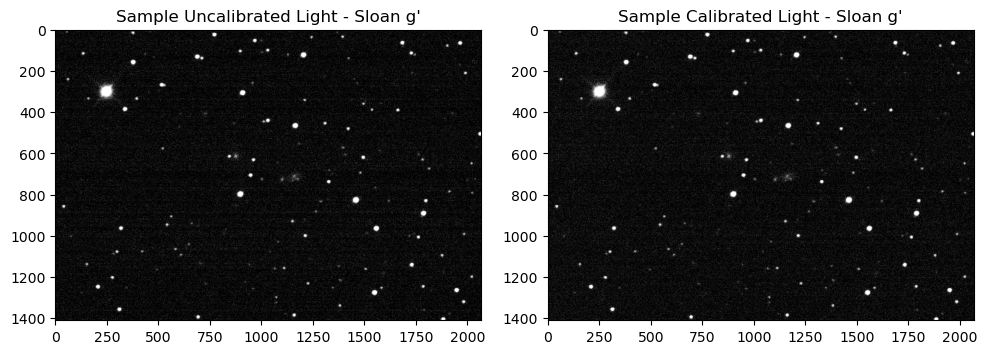

In [17]:
# Display first filter

fig, axes = plt.subplots(1, 2, figsize=(10, 10))

axes[0].imshow(transformed_sample_lights[SLOAN_G_FILTER], cmap='gray')
axes[0].set_title("Sample Uncalibrated Light - " + filter_full_names[SLOAN_G_FILTER])

axes[1].imshow(transformed_sample_calibrated_lights[SLOAN_G_FILTER], cmap='gray')
axes[1].set_title("Sample Calibrated Light - " + filter_full_names[SLOAN_G_FILTER])

plt.tight_layout()
plt.show()

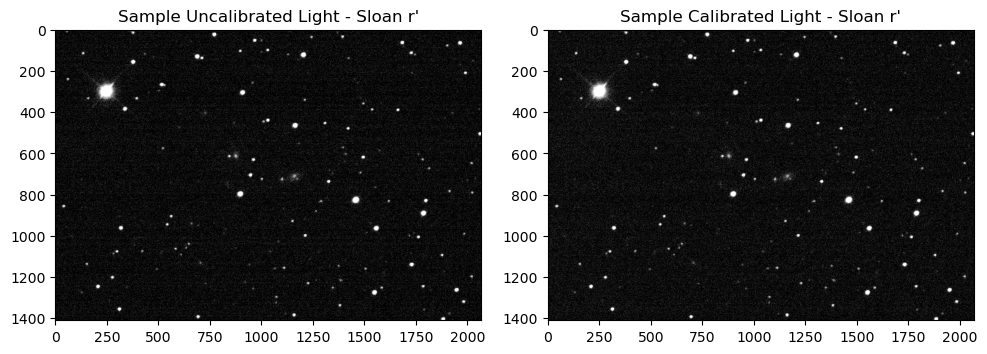

In [18]:
# Display second filter

fig, axes = plt.subplots(1, 2, figsize=(10, 10))

axes[0].imshow(transformed_sample_lights[SLOAN_R_FILTER], cmap='gray')
axes[0].set_title("Sample Uncalibrated Light - " + filter_full_names[SLOAN_R_FILTER])

axes[1].imshow(transformed_sample_calibrated_lights[SLOAN_R_FILTER], cmap='gray')
axes[1].set_title("Sample Calibrated Light - " + filter_full_names[SLOAN_R_FILTER])

plt.tight_layout()
plt.show()

### Now Aligning lights

In [19]:
reference_light_list = [lights_calibrated[0] for lights_calibrated in lights_calibrated_list]

lights_aligned_with_footprints_list = [[aa.register(l, reference_light_list[i], detection_sigma=3.0) for
                                        l in lights_calibrated_list[i]] for i in range(len(filters))]

In [34]:
first_header_list = []

for i in range(len(filters)):
    # First we pick out all the stuff for a given filter
    lights = lights_list[i]
    light_files = light_files_list[i]
    lights_aligned_with_footprints = lights_aligned_with_footprints_list[i]
    aligned_directory = aligned_directory_list[i]
    for j in range(len(lights_aligned_with_footprints)):
        # Then we write all the files for that filter
        light_header = lights[j][0].header
        light_aligned_data = lights_aligned_with_footprints[j][0]
        aligned_file = os.path.join(aligned_directory, os.path.basename(light_files[j]))
        aligned_file2 = os.path.splitext(aligned_file)[0] + '_aligned.fit'
        fits.writeto(aligned_file2, light_aligned_data, light_header, overwrite=True)

### Read Back In and Stack the Lights

In [21]:
# we'll have to do this for each filter, so make some empty lists to append to
first_light_list = []  # this contains the whole first fits file for each filter
combined_light_list = []  # this contains the combined light data for each filter

for i in range(len(filters)):
    aligned_directory = aligned_directory_list[i]
    aligned_files = ImageFileCollection(aligned_directory).files_filtered(include_path='True')
    first_light_list.append(fits.open(aligned_files[0]))
    lights = [CCDData.read(file, unit=u.adu) for file in aligned_files]
    combined_light_list.append(combine(lights, method=method))

Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'. [astropy.wcs.wcs]
Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'.
Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'. [astropy.wcs.wcs]
Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'.


In [22]:
stacked_data_list = [np.asarray(combined_light) for combined_light in combined_light_list]

# Median subtract

medians_list = [np.median(stacked_data, axis=1, keepdims=True) for stacked_data in stacked_data_list]
stacked_subtracted_list = [stacked_data_list[i] - medians_list[i] for i in range(len(filters))]

# Log stretch

stretch_function3 = log_stretch_transform(0, 100)
transform3 = np.vectorize(stretch_function3)
transformed_stacked_subtracted_list = [[transform3(data) for data in stacked_subtracted]
                                       for stacked_subtracted in stacked_subtracted_list]

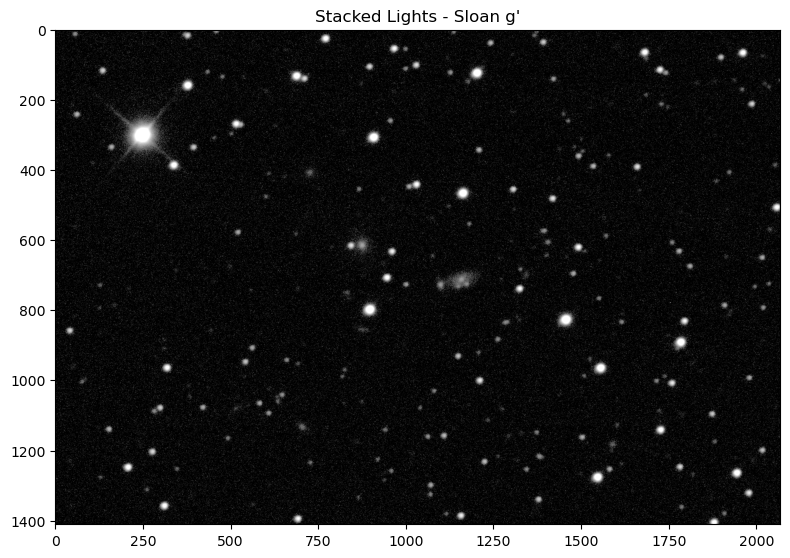

In [23]:
# Stacked Sloan g' Image

fig, axes = plt.subplots(1, 1, figsize=(8, 6))

axes.imshow(transformed_stacked_subtracted_list[SLOAN_G_FILTER], cmap='gray')

axes.set_title("Stacked Lights - " + filter_full_names[SLOAN_G_FILTER])

plt.tight_layout()
plt.show()

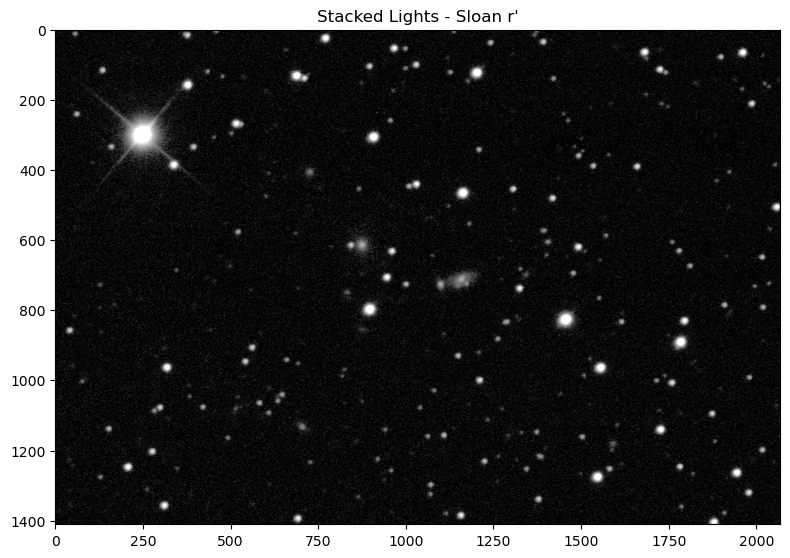

In [24]:
# Stacked Sloan r' Image

fig, axes = plt.subplots(1, 1, figsize=(8, 6))

axes.imshow(transformed_stacked_subtracted_list[SLOAN_R_FILTER], cmap='gray')

axes.set_title("Stacked Lights - " + filter_full_names[SLOAN_R_FILTER])

plt.tight_layout()
plt.show()

In [35]:
from astropy.stats import mad_std
from photutils.detection import DAOStarFinder

from astroquery.astrometry_net import AstrometryNet

import keyring

keyring.set_password('astroquery:astrometry_net', None, 'gukknblgjazqhixq')
AstrometryNet.api_key = keyring.get_password('astroquery:astrometry_net', None)


In [36]:
bkg_sigma_list = [mad_std(stacked_data) for stacked_data in stacked_data_list]
daofind = DAOStarFinder(fwhm=4., threshold=5. * bkg_sigma, brightest=100)
sources_list = [daofind(stacked_data) for stacked_data in stacked_data_list]

for sources in sources_list:
    sources.sort('flux')
    sources.reverse()

sources_list[SLOAN_G_FILTER]

NameError: name 'bkg_sigma' is not defined

In [ ]:
### get remainder of plate solving done, try to get it written out

In [ ]:
## need to make changes to the headers

In [37]:
astrometry_net_settings = {
    'scale_units': 'arcsecperpix',
    'scale_type': 'ul',
    'scale_lower': 0.9 * plate_scale_raw,
    'scale_upper': 1.1 * plate_scale_raw,
    'solve_timeout': 120
}

wcs_header_list = [AstrometryNet.solve_from_source_list(sources['xcentroid'],
                                                        sources['ycentroid'],
                                                        BINNED_SUBFRAMED_WIDTH_HEIGHT[0],
                                                        BINNED_SUBFRAMED_WIDTH_HEIGHT[1],
                                                        **astrometry_net_settings) for sources in sources_list]

NameError: name 'sources_list' is not defined

In [38]:
# Finally, we write out plate-solved files
stacked_file_list = [os.path.join(observation_directory, "stacked-" + filter + ".fits") for filter in filters]

for i in range(len(filters)):
    stacked_data = stacked_data_list[i]
    representative_header = first_header_list[i]
    wcs_header = wcs_header_list[i]
    representative_header.extend(wcs_header)
    stacked_file = stacked_file_list[i]
    fits.writeto(stacked_file, stacked_data, wcs_header, overwrite=True)


IndexError: list index out of range

In [41]:
Sloan_compiled = np.asarray(SLOAN_G_FILTER)

In [43]:
hdu - SLOAN_G_FILTER

NameError: name 'hdu' is not defined

### ePSF attempt

In [ ]:
## begin by defining a sample of stars. That's what we just did wiht the DaoStarFinder

In [ ]:
## start with some simulated data for this, adding in some background noise
#from photutils.datasets import load_simulated_hst_star_image
#from photutils.datasets import make_noise_image

#hdu = load_simulated_hst_star_image()  
#data = hdu.data  

#data += make_noise_image(data.shape, distribution='gaussian',
                         mean=10.0, stddev=5.0, seed=123)  

In [ ]:
#import matplotlib.pyplot as plt
#from astropy.visualization import simple_norm
#from photutils.datasets import (load_simulated_hst_star_image,
                                make_noise_image)

#hdu = load_simulated_hst_star_image()
#data = hdu.data
#data += make_noise_image(data.shape, distribution='gaussian', mean=10.0,
                         stddev=5.0, seed=123)
#norm = simple_norm(data, 'sqrt', percent=99.0)
#plt.imshow(data, norm=norm, origin='lower', cmap='gray')

In [42]:
## using find_peaks(0) function to find stars at initial positions. Detection value is 500 to find brightest stars

from photutils.detection import find_peaks
peaks_tbl = find_peaks(Sloan_compiled, threshold=500.0)  
peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output  
print(peaks_tbl) 

## stars are sufficiently seperated in this image, but will probably have to go into data table and mess with it manually to get data--since stars will be crowded over.

TypeError: 'NoneType' object is not subscriptable

In [ ]:
## extracting the stars--requires table of star positions in either pixel or sky coordinates.
## going to start by making 25x25 cutouts, so need to exclude thoe at the edge

size = 25
hsize = (size - 1) / 2
x = peaks_tbl['x_peak']  
y = peaks_tbl['y_peak']  
mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) &
        (y > hsize) & (y < (data.shape[0] -1 - hsize)))

In [ ]:
## creating our table of good star positions...
from astropy.table import Table
stars_tbl = Table()
stars_tbl['x'] = x[mask]  
stars_tbl['y'] = y[mask]  

In [ ]:
## background subtraction (this should already be done for us in our actual image)
from astropy.stats import sigma_clipped_stats
mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.0)  
data -= median_val

In [ ]:
## function we want needs an NDData object
from astropy.nddata import NDData
nddata = NDData(data=data)  

In [ ]:
## now, the function--which returns an EPSFStars object with the cutouts
from photutils.psf import extract_stars
stars = extract_stars(nddata, stars_tbl, size=25)  

In [ ]:
## showing the first 25 of our stars...
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
nrows = 5
ncols = 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20),
                       squeeze=True)
ax = ax.ravel()
for i in range(nrows * ncols):
    norm = simple_norm(stars[i], 'log', percent=99.0)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='gray')

In [ ]:
## now can construct EPSFBuilder class. Making ePSF with oversampling factor of 4.0. Limiting iterations to 3 here, but need to do ten or more in real life. . 
## first initiliaze with desired cutouts

from photutils.psf import EPSFBuilder
epsf_builder = EPSFBuilder(oversampling=4, maxiters=3,
                           progress_bar=False)  
epsf, fitted_stars = epsf_builder(stars) 

In [ ]:
## returned values are ePSFModel objects as new EPSFStars objects with fitted star positions and fluxes.
## showing...
norm = simple_norm(epsf.data, 'log', percent=99.0)
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='gray')
plt.colorbar()